## Sky Scan Audit - Object Detection

In [46]:
################################################
##
## Object Detection
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


#######################################################

N_EPOCHS = 10000          ## 4000
batch_size = 10   ## 5    ## 32
learning_rate =  0.1    ## 0.01   ## 1e-5 

learning_rate_mse        = 0.0005
learning_rate_pdfcontrol = 0.000001

## probably needs adjustable learning rate scheduler

#######################################################
# define mean and standard deviation of target Gaussian distribution

mean_impulse = 0.
std_impulse  = 0.01

h = 0.03                       # 0.05 >

N_error_range = 20             ## error between pred and real range (-20, 20)

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################

In [47]:

images_path = 'some_data_rc/'
dir_list = os.listdir(images_path)
print(dir_list)


['object675.jpg', 'plane3.jpg', 'plane2.jpg', 'plane737.jpg', 'plane1.jpg', 'obj5.jpg', 'object6.jpg', 'object4.jpg']


In [48]:

model = torch.hub.load('ultralytics/yolov3', 'yolov3')  # or yolov3-spp, yolov3-tiny, custom



Using cache found in /Users/user/.cache/torch/hub/ultralytics_yolov3_master
YOLOv3 🚀 2022-8-29 torch 1.12.1 CPU

Fusing layers... 
Model Summary: 261 layers, 61922845 parameters, 0 gradients
Adding AutoShape... 


In [49]:

img = 'https://ultralytics.com/images/zidane.jpg'  # or file, Path, PIL, OpenCV, numpy, list


results = model(img)

results.print()  # or .show(), .save(), .crop(), .pandas(), etc.
results.show()


/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
image 1/1: 720x1280 2 persons, 2 ties
Speed: 500.2ms pre-process, 838.9ms inference, 1.0ms NMS per image at shape (1, 3, 384, 640)


In [50]:


img = images_path + 'plane3.jpg'       # or file, Path, PIL, OpenCV, numpy, list


results = model(img)

results.print()  # or .show(), .save(), .crop(), .pandas(), etc.
results.show()


/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
image 1/1: 1729x2518 1 airplane
Speed: 78.3ms pre-process, 964.1ms inference, 0.7ms NMS per image at shape (1, 3, 448, 640)


In [51]:
for filename in dir_list:
    img = images_path + filename      # or file, Path, PIL, OpenCV, numpy, list

    results = model(img)
    results.show()
    results.save()
    
    
    

/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Saved 1 image to runs/detect/exp2
/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Saved 1 image to runs/detect/exp3
/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Saved 1 image to runs/detect/exp4
/Users/user/opt/anaconda3

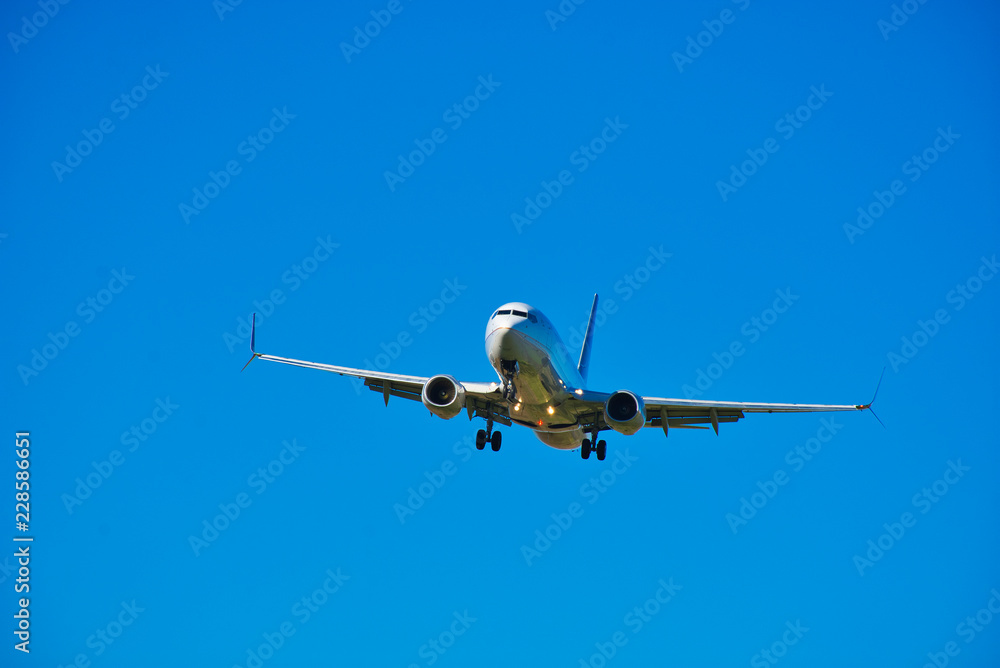

In [52]:
img = read_image(images_path + 'plane2.jpg')

img = T.ToPILImage()(img)

## img.show()

img



In [53]:

detected_images_path = 'runs/detect/detected_imgs_RC/'
dir_list = os.listdir(detected_images_path)
print(dir_list)






['plane737.jpg', 'plane1.jpg', 'obj5.jpg', 'object6.jpg', 'object4.jpg']


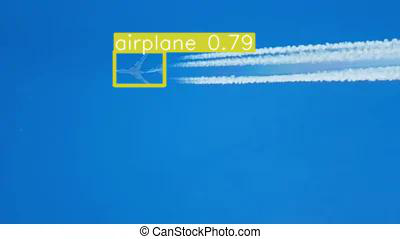

In [54]:


img_path1 = detected_images_path + 'plane737.jpg'      # or file, Path, PIL, OpenCV, numpy, list
img_path2 = detected_images_path + 'plane1.jpg'        # or file, Path, PIL, OpenCV, numpy, list
img_path3 = detected_images_path + 'obj5.jpg'          # or file, Path, PIL, OpenCV, numpy, list
img_path4 = detected_images_path + 'object6.jpg'       # or file, Path, PIL, OpenCV, numpy, list
img_path5 = detected_images_path + 'object4.jpg'       # or file, Path, PIL, OpenCV, numpy, list


img1 = T.ToPILImage()(read_image(img_path1))
img2 = T.ToPILImage()(read_image(img_path2))
img3 = T.ToPILImage()(read_image(img_path3))
img4 = T.ToPILImage()(read_image(img_path4))
img5 = T.ToPILImage()(read_image(img_path5))

img1


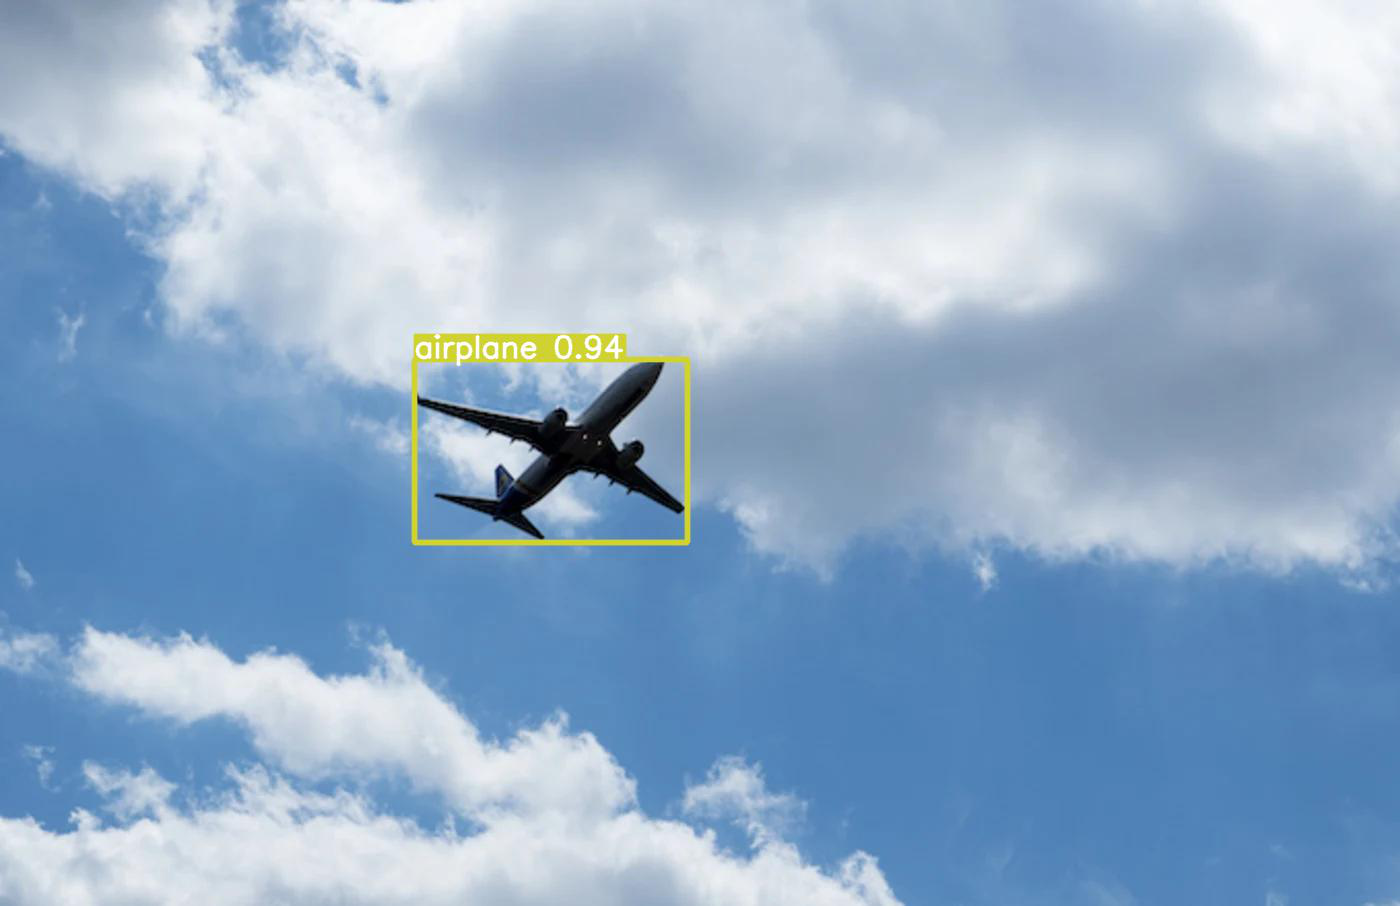

In [55]:
img2


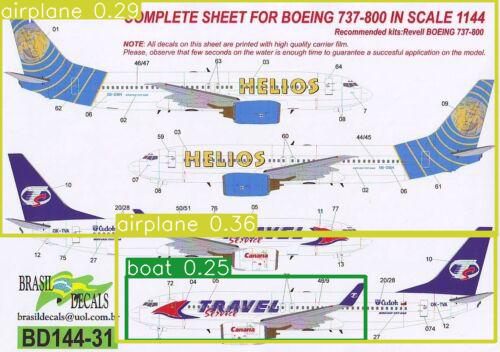

In [56]:
img3


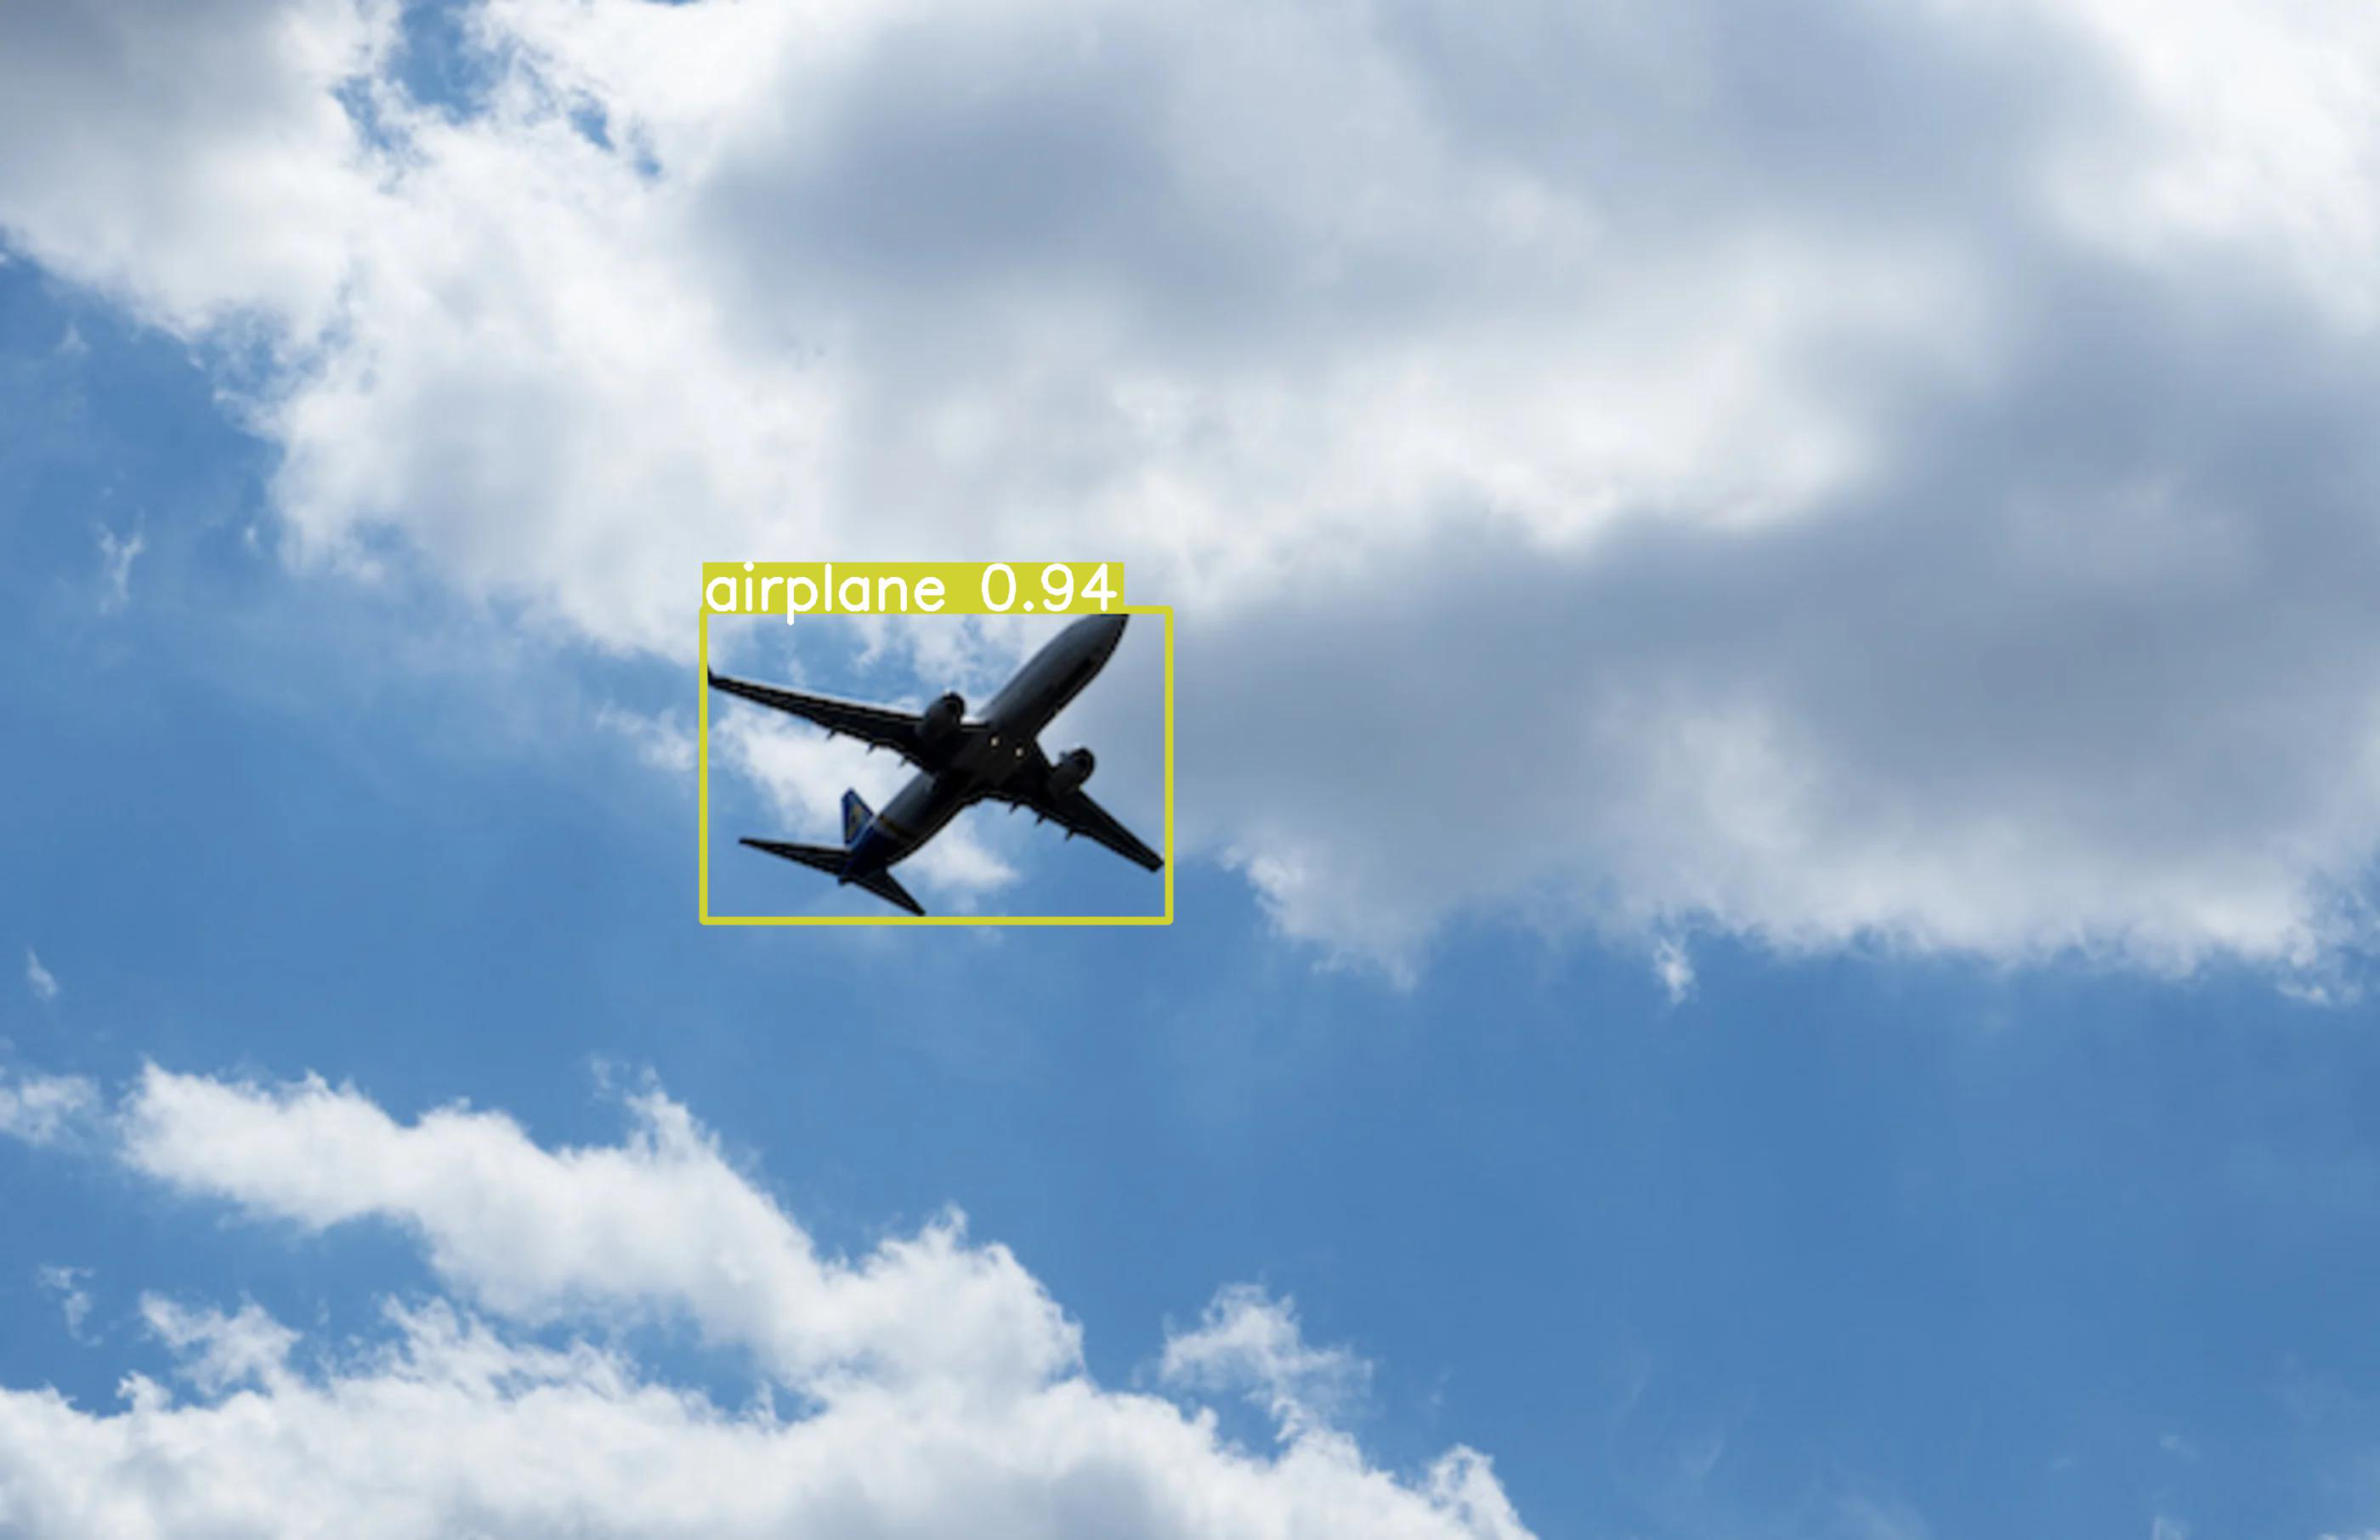

In [57]:
img4


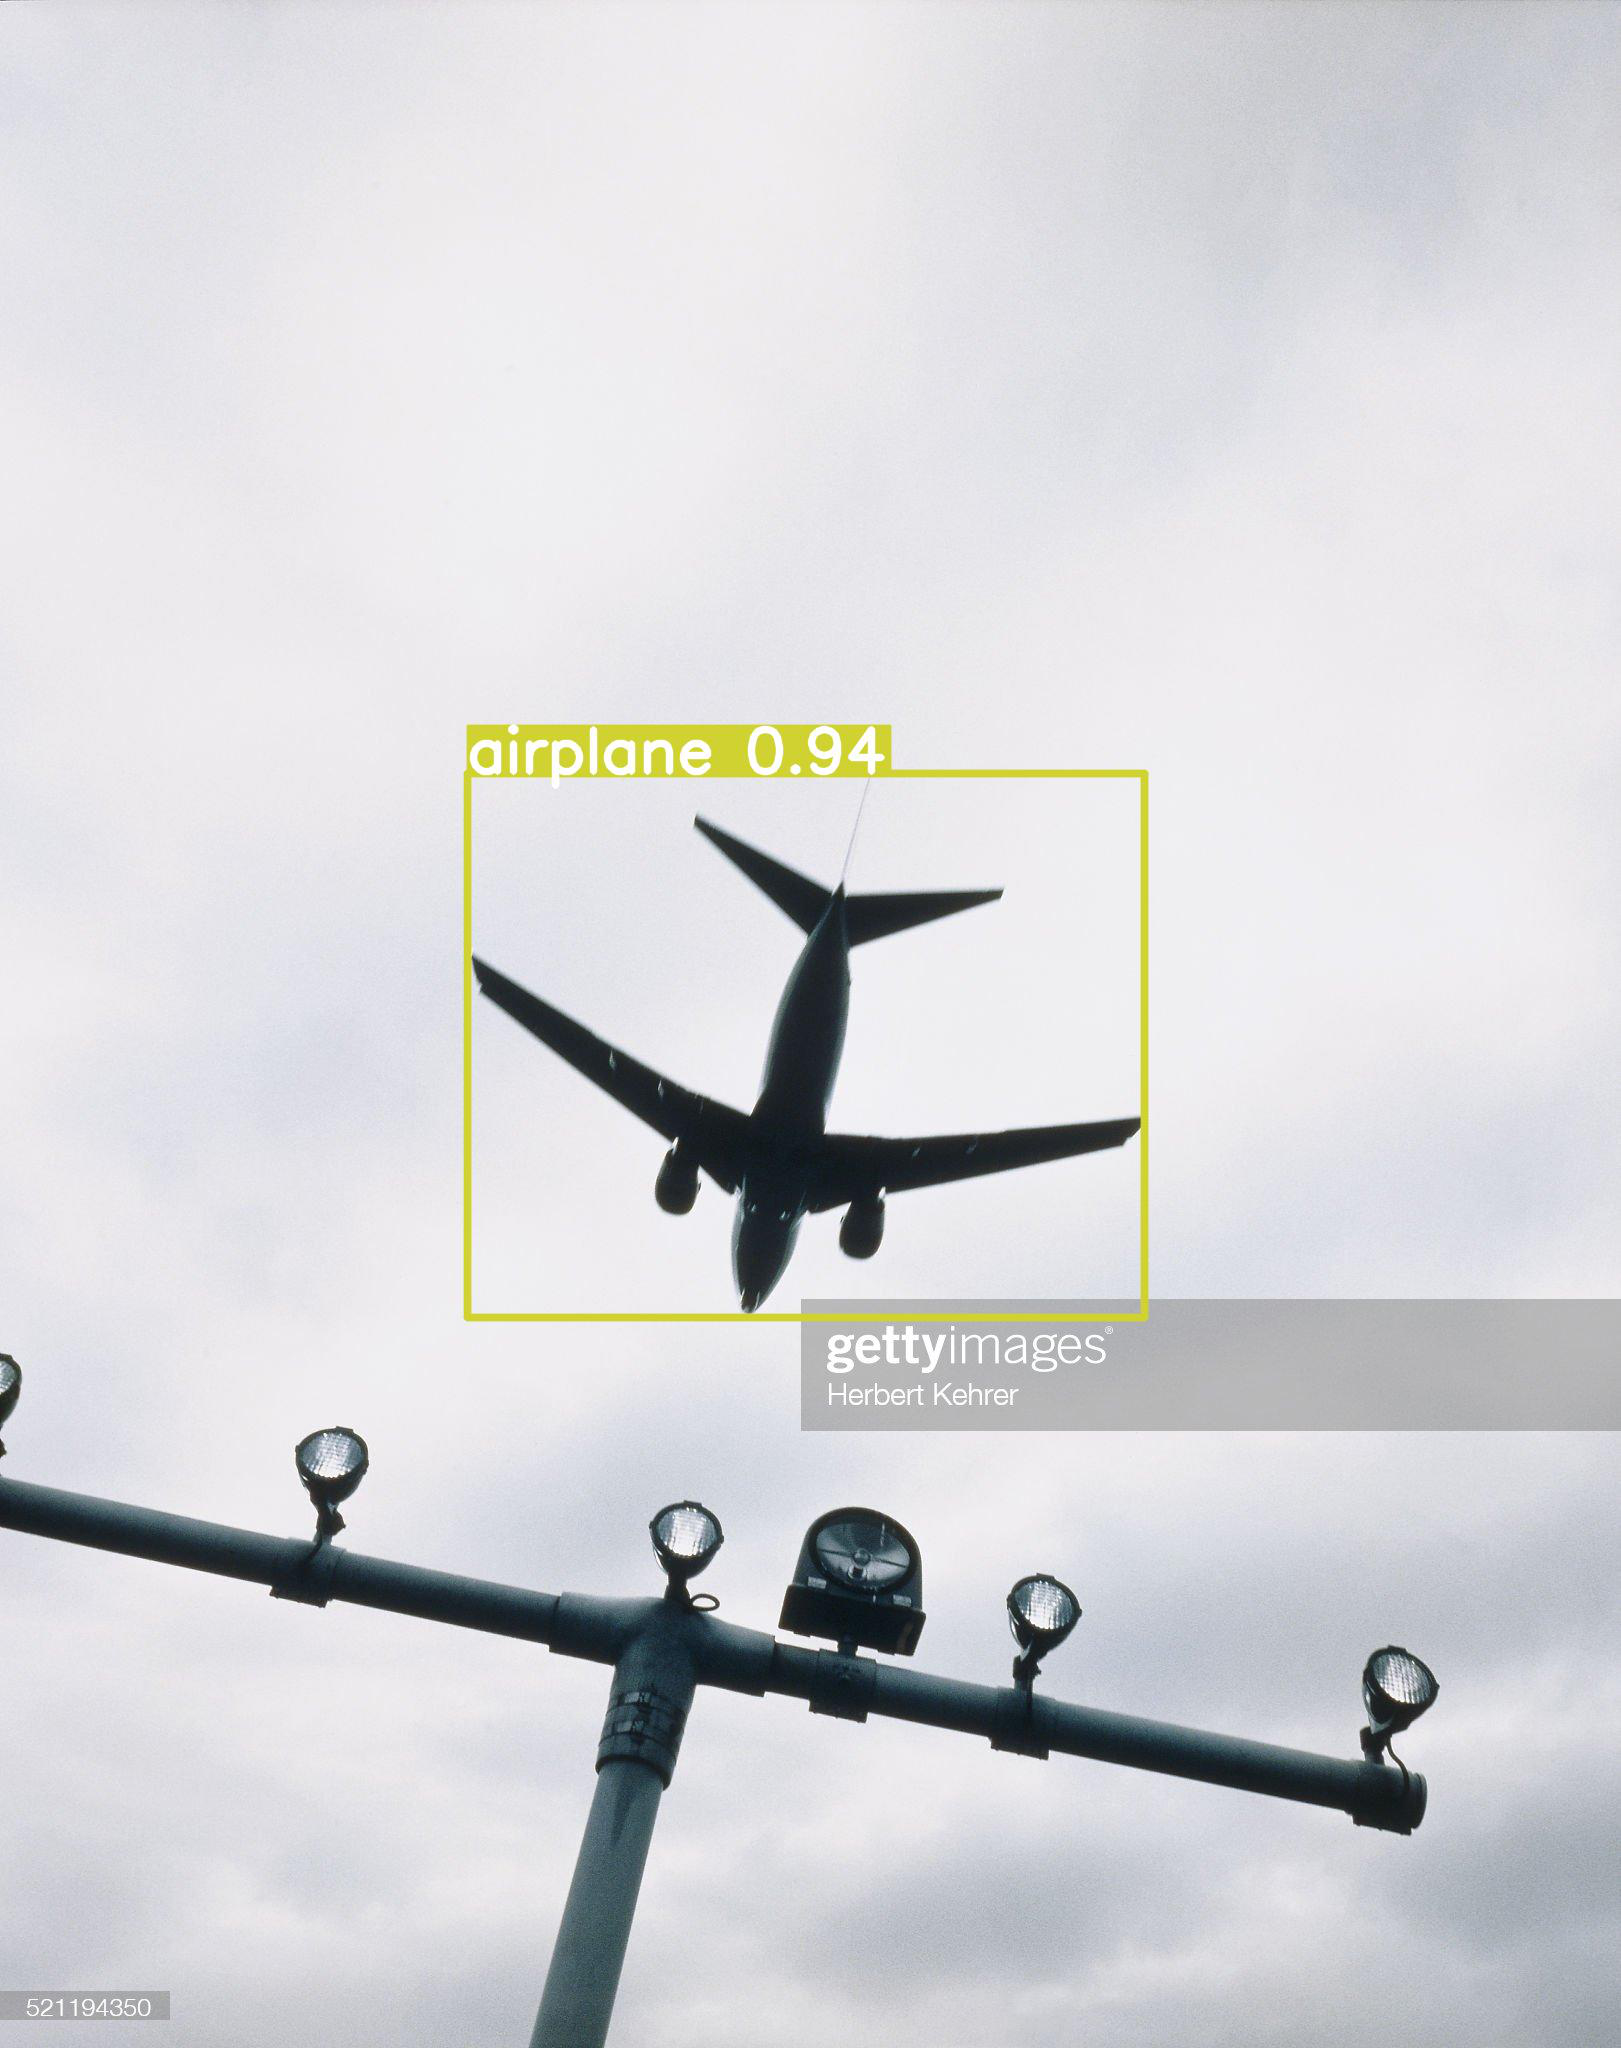

In [58]:

img5

## Detect and crop

In [61]:

images_path = 'some_data_rc/'
dir_list = os.listdir(images_path)
print(dir_list)

for filename in dir_list:
    img = images_path + filename      # or file, Path, PIL, OpenCV, numpy, list

    results = model(img)
    
    results.crop()
    results.show()
    results.save()
    
    
    


['object675.jpg', 'plane3.jpg', 'plane2.jpg', 'plane737.jpg', 'plane1.jpg', 'obj5.jpg', 'object6.jpg', 'object4.jpg']


Saved 1 image to runs/detect/exp13
Saved results to runs/detect/exp13

Saved 1 image to runs/detect/exp14
/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Saved 1 image to runs/detect/exp15
Saved results to runs/detect/exp15

Saved 1 image to runs/detect/exp16
/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Saved 1 image to runs/detect/exp17
Saved results to runs/detect/exp17

Saved 1 image to runs/detect/exp18
/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/torch/amp/autocast_mode